In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

'git' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [4]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('object_detection/test_images/image1.jpg'),
 WindowsPath('object_detection/test_images/image2.jpg'),
 WindowsPath('object_detection/test_images/image3.jpg')]

In [7]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [21]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = image_path
  #image_np = image_path
  # Actual detection.
  image_np = cv2.cvtColor(image_np , cv2.COLOR_BGR2RGB)
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2,min_score_thresh = 0.1)

  #display(Image.fromarray(image_np))
  image_np = cv2.cvtColor(image_np , cv2.COLOR_BGR2RGB)
  bicycle_detection(image_np,output_dict['detection_classes'],output_dict['detection_scores'],output_dict['detection_boxes'])
  return image_np

In [24]:
from datetime import datetime 
def bicycle_detection(image ,classes,scores,boxes):
    for i in range(10):
        now = datetime.now()
        dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
        
        if(classes[i] == 2 and scores[i]>0.8):
            file_name=os.path.join('E:/TEST/',dt_string+'.jpg')
            cv2.imwrite(file_name,image)

# from datetime import datetime

def bicycle_detect(image,classes,score,boxes):
    
    for i in range(10):
        if(classes[i]==2 and score[i]>0.8):
            
            h,w=image.shape[0:2]
            #image.shape=[height,width,3]
            
            ymin,xmin,ymax,xmax=boxes[i]

            now = datetime.now()
            dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
            
            center=(int(((xmin+xmax)/2)*w),int(((ymin+ymax)/2)*h))
            cv2.circle(image,center,10,(0,0,255),-1)
            
            file_name=os.path.join('E:/TEST/',dt_string+'.jpg')
            cv2.imwrite(file_name,image)

In [25]:
import cv2

video=cv2.VideoCapture('video.mp4')

while(True):
    ret,img=video.read()
    img=show_inference(detection_model,img)
    cv2.imshow('LIVE',img)
    k=cv2.waitKey(1)
    
    if(k==27):
        break
cv2.destroyAllWindows()


## ```output_dict[detection_classes]``` 

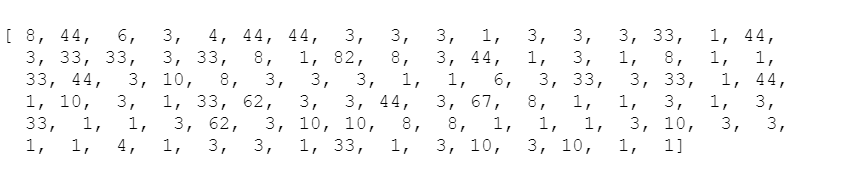

## ```category_index```
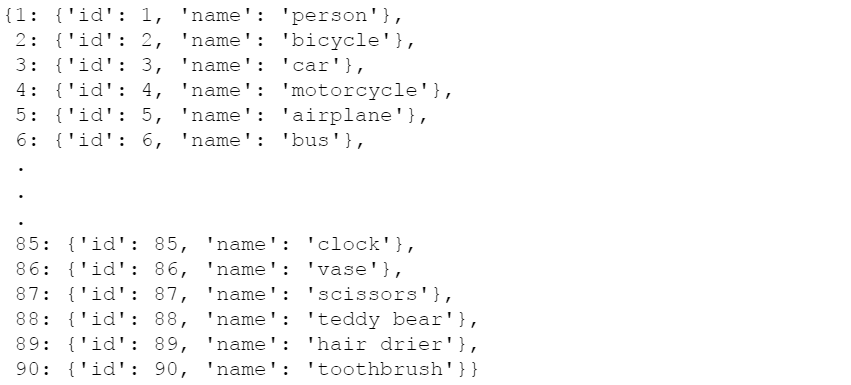